## Questions

1. Which distribution does the standard deviation in equation for RANSAC error threshold $t = 5.99\sigma^2$ represent?

A: I'm investigating

In [11]:
# Hard path reference, can be run without installing robot_perception
from robot_perception.src.homography_estimation import normalized_dlt, util, ransac
# After installing robot_perception package can run this directly
#from homography_estimation import normalized_dlt, util
import numpy as np
import random
from scipy.ndimage import imread
import matplotlib.pyplot as plt
%matplotlib inline


img1 = imread("boat/img1+points.png")
img2 = imread("boat/img2+points.png")

with open("boat/homography.txt") as f:
    lines = f.readlines()

# Get the text coordinates
lines[0] = lines[0][lines[0].find('[') + 1:lines[0].find(']')]
lines[1] = lines[1][lines[1].find('[') + 1:lines[1].find(']')]

# Split coordinate pairs
lines[0] = lines[0].split(';')
lines[1] = lines[1].split(';')

# Map coordinates to 2D int arrays
x = []
x_tick = []
for i in range(len(lines[0])):
    x.append(list(map(int, lines[0][i].split(','))))
    x_tick.append(list(map(int, lines[1][i].split(','))))

x = np.array(x)
x_tick = np.array(x_tick)

In [12]:
H = normalized_dlt.get_homography(x, x_tick)
#print(np.linalg.inv(H))

average_error = 0.
for i in range(len(x)):
    distance = util.calculate_transfer_error_symmetric(x[i], x_tick[i], H)
    #print(distance)
    average_error = average_error + distance

average_error = average_error / len(x)

In [16]:
ransac_inst = ransac.RANSAC(average_error*45, 0.4)
inliers, homography_ransac = ransac_inst.get_homography(x, x_tick)
print(inliers)
print(homography_ransac)

[7, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24]
[[  8.63500473e-01   1.65677146e-01   2.16216862e+01]
 [ -2.12920588e-01   8.14596256e-01   1.43535895e+02]
 [  9.12612546e-06  -1.56919215e-04   1.04072519e+00]]


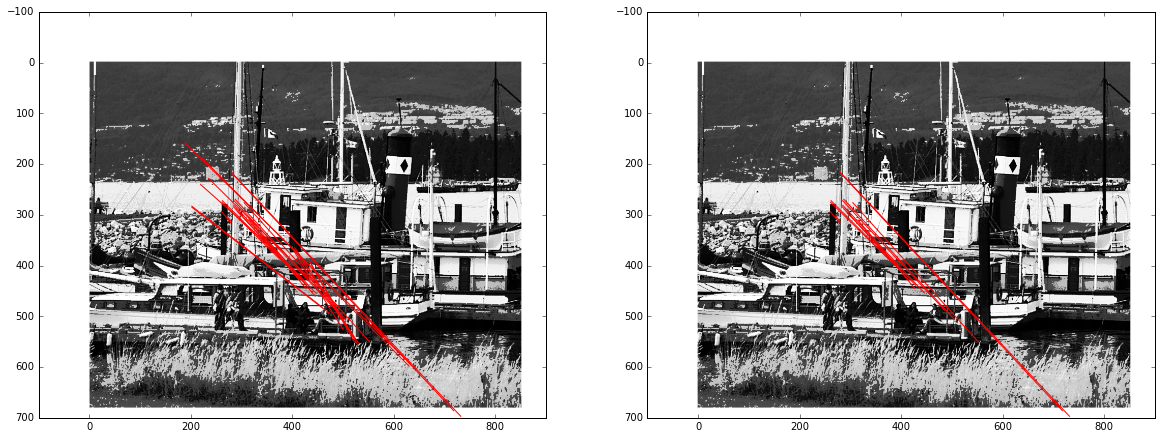

In [5]:

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
util.plot_lines_on_image(img1, x, x_tick)
plt.subplot(1,2,2)
util.plot_lines_on_image(img1, x[inliers], x_tick[inliers])
plt.show()

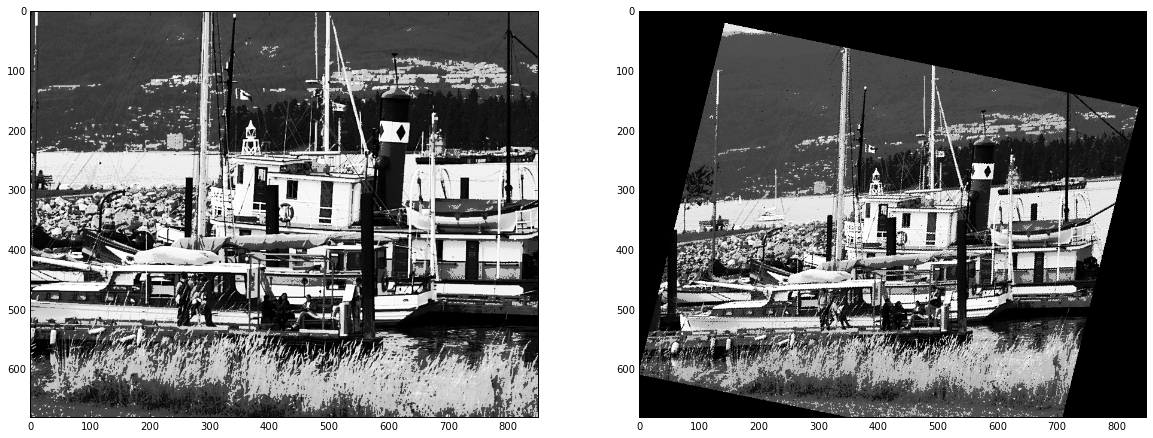

In [10]:
img2_recon_ransac = util.transform_image(img2, homography_ransac)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(img1, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img2_recon_ransac, cmap='gray')

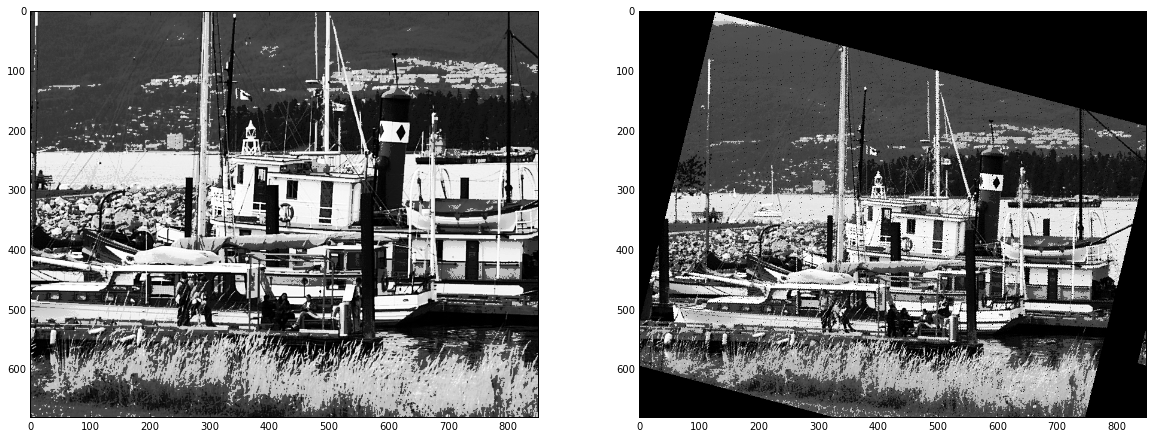

In [9]:
img2_recon = util.transform_image(img2, H)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(img1, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img2_recon, cmap='gray')